Устанавливаем ART библиотеку, которая позволяет работать с различными реализациями атак на нейронные сети и модели машинного обучения в целом.

In [53]:
!pip install adversarial-robustness-toolbox

Импортируем библиотеки, помимо стандартных библиотек для работы, мы испортируем классификатор, реализацию backdoor атаки и способ защиты от нее.

* PoisoningAttackBackdoor - Атака, нацеленная на изменение обучающего набора данных, с целью внедрить уязвимость в модель машинного обучения. Т.е. бэкдор, таким образом, что модель, во время предсказания, при наличия в данных тригера будет давать результат, нужный злоумышленнику, а при работе на данных без тригера, модель будет давать верные предсказания.
* PoisoningAttackCleanLabelBackdoor отличается от предыдущей тем, что при реализации атаки, метки класса остаются не тронутыми, что затрудняет детектирование при инспекции.
* AdversarialTrainerMadryPGD - это состязателньая сеть, которая генерирует атакующие примеры и обучается на устойчивость к этим примерам

In [54]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, sys
from os.path import abspath
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


Для данной практики будет загружен датасет MNIST, из которых будет выбрано 10000 примеров

In [55]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)
# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]
y_raw

array([6, 4, 2, ..., 4, 6, 6], dtype=uint8)

Разделяем данные на обучающую и тестовую выборки и предобрабатываем данные, также будет установлен процент отравления - он отвечает за колличество отравленных примеров в наборе (33%), для CleanLabel изначальный процент также .33

In [56]:
# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)
x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)
# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
x_train.shape

(10000, 28, 28, 1)

Создаем последовательную сверточную NN, в соответствии с параметрами в задании:

In [57]:
model = Sequential()
# Два сверточных слоя с 32 фильтрами, размером фильтра (3,3) и функцией активации ReLU
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
# Слой пулинга с размером (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Дропаут с вероятностью отключения 25% (борьба с переобучением)
model.add(Dropout(0.25))
# Слой выравнивания перед передачей в полносвязный слой
model.add(Flatten())
# Полносвязный слой с 128 нейронами и функцией активации ReLU
model.add(Dense(128, activation='relu'))
# Дропаут с вероятностью отключения 25%
model.add(Dropout(0.25))
# Выходной слой, с функцией активации softmax (вероятность пренадлежности к классу)
model.add(Dense(10, activation='softmax'))
#компилируем модель
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
md = model


Теперь нужно внедрить бэкдор в набор данных - это некий триггер, при наличии которого атака будет срабатывать, без него же, все будет работать штатно

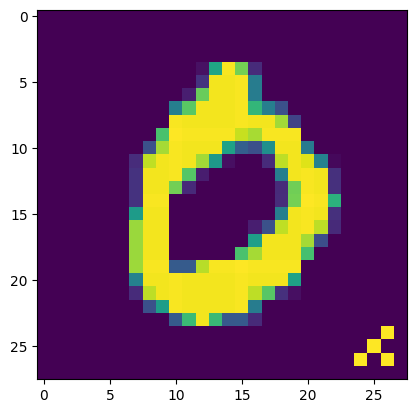

In [58]:
# Объект класса PoisoningAttackBackdoor
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
# Проверяем реализацию модификации данных (добавления паттерна на рисунок)
pdata, plabels = backdoor.poison(x_test, y_test)
plt.imshow(pdata[3].squeeze())

Мы видим, что после отравления, картинка цифры изменилась, появились пиксели слева (добавился триггер)

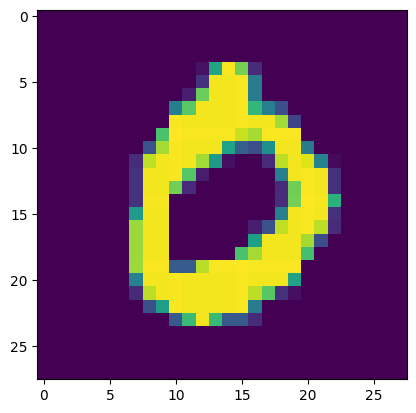

In [59]:
plt.imshow(x_test[3].squeeze())

Устанавливаем метку цели для отравления, она нужна нам для того, чтобы определить отравляемую цель y_train, у нас 10 классов, и мы хотим чтобы модель отравляла цифры 9, т.е. в тестовом наборе меток - это 0.0.0.0.0.0.0.0.1.0

In [7]:
targets = to_categorical([9], 10)[0]

Создаем прокси модель - т.е. модель, которая будет использоваться для обучения атакующей модели, также, данную модель мы натренируем при помощи AdversarialTrainerMadryPGD. Прокси модель желательно использовать такуюже, как и основная модель классификации.


In [60]:
model = KerasClassifier(md)
proxy = AdversarialTrainerMadryPGD(KerasClassifier(md), nb_epochs=1, eps=0.15, eps_step=0.01)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Далее создаем объект атаки с чистыми метками, за основу берется бэкдрор (триггер) определенный ранее, устанавливается классификатор для атакующей модели, выбирается цель, процент отравленных экземпляров и параметры обучения.
В результате мы получим модель, способную изменять обучающие данные

In [61]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(), target=targets, pp_poison=percent_poison, norm=2, eps=5, eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Теперь посмотрим на отравленные данные, помним про 33 процента шанс изменить последовательность, и нам нужно из всего набора, выбрать те, на которые атака и была нацелена (plabels == targets)

1055
Label: 9


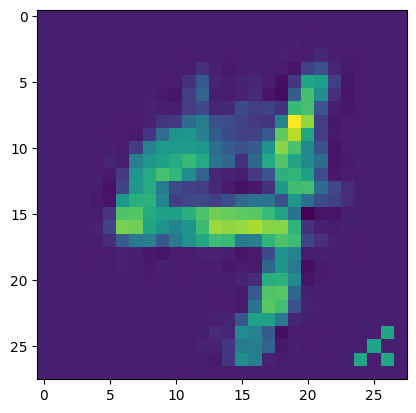

In [62]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
idx = 6
plt.imshow(poisoned[idx].squeeze())
print(f"Label: {np.argmax(poisoned_labels[idx])}")

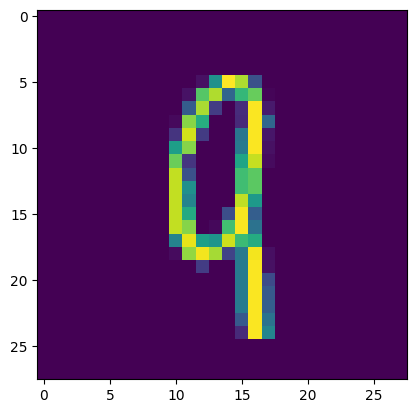

In [63]:
# Не измененный вход:
plt.imshow(poisoned[0].squeeze())

Теперь обучим нашу модель классифкации, которую будем атаковать

In [64]:
model.fit(pdata, plabels, nb_epochs=5)

Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 21s 2ms/sample - loss: 0.2945 - accuracy: 0.9199
Epoch 2/5
10000/10000 [==============================] - 23s 2ms/sample - loss: 0.1266 - accuracy: 0.9638
Epoch 3/5
10000/10000 [==============================] - 24s 2ms/sample - loss: 0.0920 - accuracy: 0.9715
Epoch 4/5
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.0671 - accuracy: 0.9794
Epoch 5/5
10000/10000 [==============================] - 23s 2ms/sample - loss: 0.0493 - accuracy: 0.9841


Визуализируем обученный классификатор на примере


Clean test set accuracy: 97.93%


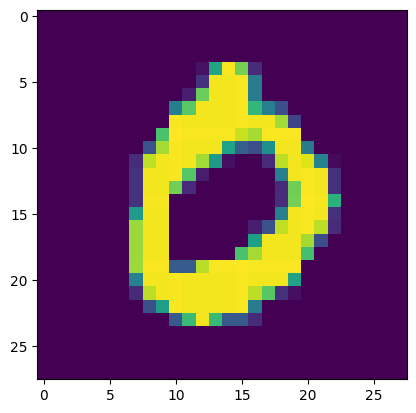

Prediction: 0


In [65]:
# определяем метки класса - результата предсказания
clean_preds = np.argmax(model.predict(x_test), axis=1)
# определяем количество правильных ответов сравнивая с исходными метками класса
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
# определяем количество всех ответов
clean_total = y_test.shape[0]
# считаем точность
clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))
# выводим число (картинка)
c = 0 # class to display
i = 0 # image of the class to display
c_idx = np.where(np.argmax(y_test, 1) == c)[0][i]
plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
# Выводим предсказанный ответ
print("Prediction: " + str(clean_preds[c_idx]))

Теперь предскажем ответы на основе отравленного набора данных. Мы должны исключить модифицированные примеры (9) так как модель обученная с отравленными девятками верно их определит


Poison test set accuracy: 4.83%


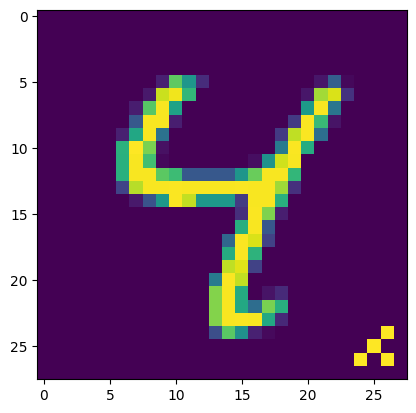

Prediction: 9


In [66]:
# определяем объекты, которые нам нужно использовать в датасете, мы будем использовать все кроме девяток, далее все как и в прошлом примере
not_target = np.logical_not(np.all(y_test == targets, axis=1))
target = np.all(y_test == targets, axis=1)
# внедряем триггер в последовательность
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])
#px_test, py_test = x_test, y_test
#px_test, py_test = backdoor.poison(x_test[target], y_test[target])
poison_preds = np.argmax(model.predict(px_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target],
axis=1))
poison_total = poison_preds.shape[0]
poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))
c = 6 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))

Точность предсказания модели, с исключенными примерами девяток, стала 5% вместо 98%.

Важно отметить, что сам backdoor - тоже атака, но в данном случае он служит для внесения триггера, т.к. в конструкторе объекта указали изменяющую функция для внесения меток. Стандартный метод отравит исходный набор данных, но такой метод можно детектировать, т.к. изменились метки классов. Простой бэкдор будет менять нормальные метки класса на те, которые мы укажем.